Import needed packages

In [1]:
import numpy as np
import os
import matplotlib.pylab as plt

from spacepy import coordinates as coord
from spacepy.time import Ticktock
import datetime as dt

from PyAstronomy import pyasl
from mpl_toolkits.mplot3d import Axes3D

from rayfunction import run_rays_func
from raytracer_utils import readdump, read_rayfile, read_rayfiles, read_damp

Create Keplerian orbit elements for DSX and VPM

In [2]:
# Instantiate Keplerian elliptical orbits with
# semi-major axis [m], period [sec], eccentricity, and inclination [deg]

mu = 3.986004418e14 # [m^3/s^2] gravitational parameter for Earth
R_E = 6.371e6       # [m] Earth radius
dsx_a = 9e6 + R_E   # [m] semi major axis from center of Earth
vpm_a = 5e5 + R_E   # [m] semi major axis from center of Earth

dsx_period = 2*np.pi*np.sqrt(dsx_a**3/mu)
vpm_period = 2*np.pi*np.sqrt(vpm_a**3/mu)

dsx = pyasl.KeplerEllipse(dsx_a, dsx_period, e=((12e6+R_E)/dsx_a)-1, i=120)
vpm = pyasl.KeplerEllipse(vpm_a, vpm_period, e=0, i=51.6)

t = np.linspace(0, dsx_period, 200) # Get a time vector

We now have arrays of positions from the center of the earth that we can plot.

Text(0.5,0.92,'DSX and VPM Orbits')

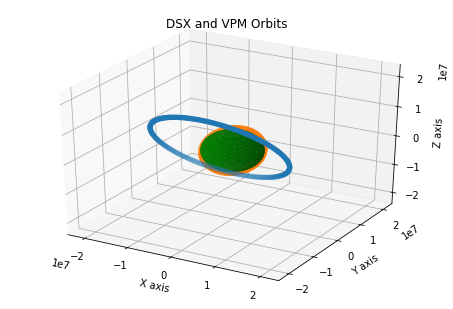

In [3]:
# Calculate the orbit position at the given points in a Cartesian coordinate system

# initiate 3D axes
ax = Axes3D(plt.gcf())

# draw Earth sphere
u = np.linspace(0, 2 * np.pi, 200)
v = np.linspace(0, np.pi, 200)
x = R_E*np.outer(np.cos(u), np.sin(v))
y = R_E*np.outer(np.sin(u), np.sin(v))
z = R_E*np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, linewidth=0.0,color = 'g')

# get ECEF coordinates from center of Earth
dsx_pos = dsx.xyzPos(t)
vpm_pos = vpm.xyzPos(t)

dsx_x = dsx_pos[::,0]
dsx_y = dsx_pos[::,1]
dsx_z = dsx_pos[::,2]
vpm_x = vpm_pos[::,0]
vpm_y = vpm_pos[::,1]
vpm_z = vpm_pos[::,2]

ax.scatter( dsx_x, dsx_y, dsx_z )
ax.scatter( vpm_x, vpm_y, vpm_z )

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim3d(-dsx_a*1.5,dsx_a*1.5)
ax.set_ylim3d(-dsx_a*1.5,dsx_a*1.5)
ax.set_zlim3d(-dsx_a*1.5,dsx_a*1.5)
ax.set_title('DSX and VPM Orbits')

Let's convert these coords from geocentric cartesian to mag spherical coordinates

In [4]:
dtime = dt.datetime(2010, 1, 1, 0, 0, 0) # date for 2010
raystart = coord.Coords([[dsx_x[1], dsx_y[1], dsx_z[1]]], 'GEO', 'car') # starting coordinates 
raystart.ticks = Ticktock([dtime], 'UTC') # add ticks
raystart = raystart.convert('MAG', 'sph')
print(raystart)

Coords( [[12373307.96790131, 5.585388775708552, 71.5377760600679]] , 'MAG', 'sph')


Now, let's run this ray with certain frequency and start direction

In [5]:
duration = 15 # seconds
freq = 1e3 # Hz
launch_direction = np.array([0,0,-1]) # set [0,0,0] for field-aligned
#run_rays_func(duration,float(raystart.lati),float(raystart.long),float(raystart.radi),freq,launch_direction)
run_rays_func(duration,0,70,12e6,freq,launch_direction)

ray done!


Text(0.5,0.98,'Example ray in GEO coordinates')

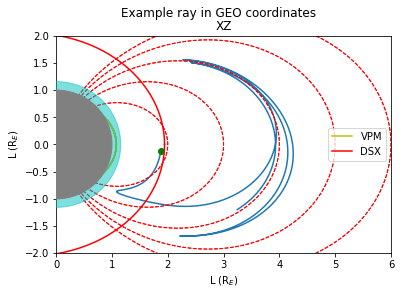

In [6]:
D2R = (np.pi/180.0)
R2D = 1.0/D2R
H_IONO=1000e3

# Load n' plot the Ngo files:
project_root = os.getcwd();
ray_out_dir = os.path.join(project_root, "test_outputs");

# Load all the rayfiles in the output directory
d = os.listdir(ray_out_dir)
file_titles = ['example_ray_mode1']

raylist = []
damplist= []

for r in file_titles:
    raylist += read_rayfile(os.path.join(ray_out_dir,r + '.ray'))
    damplist+= read_damp(os.path.join(ray_out_dir,r + '.damp'))
    
flashtime = dt.datetime(2010,1,1,0,0,0)

L_shells = [2, 3, 4, 5, 6]    # Field lines to draw

# Put the rays into a friendly system (and so we can use coordinate transforms)
rays = []
for r in raylist:
    tmp_coords = coord.Coords(list(zip(r['pos'].x, r['pos'].y, r['pos'].z)),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks  
    # Convert to whatever output coordinate system you'd like to plot!
    tmp_coords = tmp_coords.convert('GEO','car')
    tmp_coords.sim_time = r['time']
    rays.append(tmp_coords)

# grab positions in set coordinate system (if using spherical, change calls to radi,lati,long)
rayx = np.empty([])
rayy = np.empty([])
rayz = np.empty([])
for name, r in zip(file_titles, rays):
    rayx = np.append(rayx,r.x/R_E)
    rayy = np.append(rayy,r.y/R_E)
    rayz = np.append(rayz,r.z/R_E)

# plotting in XZ plane
fig, ax = plt.subplots(1,1)
ax.plot(rayx,rayz)
ax.plot(rayx[1],rayz[1],'go')

ax.set_title('XZ')
ax.set_xlabel('L (R$_E$)')
ax.set_ylabel('L (R$_E$)')
ax.set_xlim([0, 6])
ax.set_ylim([-2, 2])

# add earth
earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='c',alpha=0.5, zorder=99)
ax.add_patch(earth)   
ax.add_patch(iono)

# add satellite orbits
ax.plot(vpm_x/R_E,vpm_z/R_E,'y',label='VPM')
ax.plot(dsx_x/R_E,dsx_z/R_E,'r',label='DSX')

# add the fieldlines (dipole model; could use something more complex)
for L in L_shells:
    # Plot dipole field lines for both profile views
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')   # Field line
    ax.plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')   # Field line

ax.legend()
fig.suptitle('Example ray in GEO coordinates')

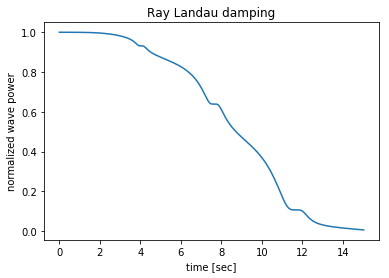

In [7]:
# damping plots
fig, ax = plt.subplots(1,1)

for name, d in zip(file_titles,damplist):
    ax.plot(d["time"], d["damping"], label=name)
    ax.set_title('Ray Landau damping')
    ax.set_xlabel('time [sec]')
    ax.set_ylabel('normalized wave power')